# Model Evaluation Results


In [5]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np

In [6]:
# Importing results calculated on Colab servers
import json

# Read the file
with open('results/json/results.json', 'r') as f:
    results = json.load(f)

results.keys()


dict_keys(['esnli', 'mnli', 'cose'])

In [7]:
model_names = ['xsmall', 'small', 'base', 'large']
model_sizes = ['xsmall (22m)', 'small (44m)', 'base (86m) ', 'large (304m)']
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']
metric_names = ['accuracy', 'percision', 'recall', 'f1']
metrics_nli = [accuracy_score, lambda x,y: precision_score(x,y, average='macro'), lambda x,y: recall_score(x,y, average='macro'), lambda x,y: f1_score(x,y, average='macro')]
metrics_cose = [accuracy_score]

In [8]:
def print_key_tree(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            print_key_tree(value, indent + 1)
        elif isinstance(value, list):
            if all(isinstance(i, dict) for i in value):
                for sub_dict in value:
                    print_key_tree(sub_dict, indent + 1)

print_key_tree(results['cose'])


true
xsmall
  pred
  accuracy
small
  pred
  accuracy
base
  pred
  accuracy
large
  pred
  accuracy


## Calculating Confidence Intervals Using Bootstrapping


In [6]:
def get_confidence_intervals(true, pred, metric_function, n_iterations = 1000, alpha = 0.95):
    
    bootstrapped_scores = []
    for i in range(n_iterations):
        boot_true, boot_pred = resample(true, pred)
        score = metric_function(boot_true, boot_pred)
        bootstrapped_scores.append(score)

    lower = np.percentile(bootstrapped_scores, (1-alpha)/2 * 100)
    upper = np.percentile(bootstrapped_scores, (alpha + (1-alpha)/2) * 100)

    return lower, upper



In [78]:
# Initialise dictionary
confidence_intervals = {
    'esnli':{
        'xsmall':{
            'accuracy': (),
            'percision': (),
            'recall': (),
            'f1': (),
        },
        'small':{
            'accuracy': (),
            'percision': (),
            'recall': (),
            'f1': (),
        },
        'base':{
            'accuracy': (),
            'percision': (),
            'recall': (),
            'f1': (),
        },
        'large':{
            'accuracy': (),
            'percision': (),
            'recall': (),
            'f1': (),
        },                                
    },
    'mnli':{
        'xsmall':{
            'accuracy': (),
            'percision': (),
            'recall': (),
            'f1': (),
        },
        'small':{
            'accuracy': (),
            'percision': (),
            'recall': (),
            'f1': (),
        },
        'base':{
            'accuracy': (),
            'percision': (),
            'recall': (),
            'f1': (),
        },
        'large':{
            'accuracy': (),
            'percision': (),
            'recall': (),
            'f1': (),
        },                                
    } ,  
    'cose':{
        'xsmall':{
            'accuracy': (),
        },
        'small':{
            'accuracy': (),
        },
        'base':{
            'accuracy': (),
        },
        'large':{
            'accuracy': (),
        },                                
    }     
}


In [80]:
# calculate confidence intervals
for dataset in datasets:

    if dataset == 'cose':
        metrics = metrics_cose
    else:
        metrics = metrics_nli

    true = results[dataset]['true']
    for model_name in model_names:
        pred = results[dataset][model_name]['pred']
        for i, metric in enumerate(metrics):
            
            confidence_intervals[dataset][model_name][metric_names[i]] = get_confidence_intervals(true, pred, metric)
            

In [83]:
confidence_intervals['mnli']['xsmall']['percision']

(0.8715758305869027, 0.8843496597479306)

In [10]:
true, pred = results['esnli']['true'], results['esnli']['xsmall']['pred']

print(get_confidence_intervals(true, pred, accuracy_score, n_iterations = 1000, alpha = 0.95))
print(results['esnli']['xsmall']['accuracy'])

(0.9144457427352165, 0.9254216622637675)
0.9203413940256046


In [ ]:
# Save the dictionary as a JSON file
with open('results/json/confidence_intervals.json', 'w') as json_file:
    json.dump(confidence_intervals, json_file, indent=4)

# Plotting results

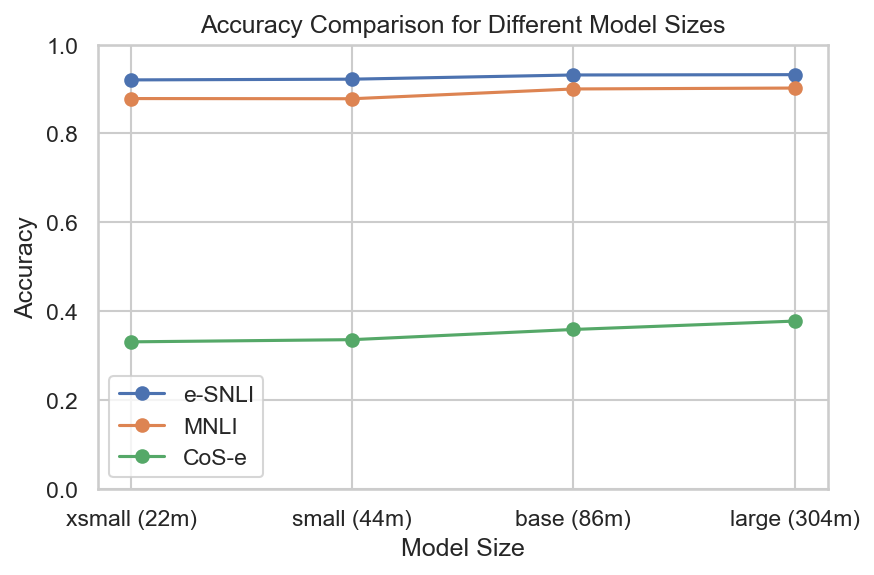

In [84]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# Iterate through each dataset
for i,dataset in enumerate(datasets):
    dataset_results = results[dataset]
    accuracies = [dataset_results[model]['accuracy'] for model in model_names]
    ax.plot(model_sizes, accuracies, marker='o', label=dataset_labels[i])

ax.set_title("Accuracy Comparison for Different Model Sizes")
ax.set_xlabel("Model Size")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)  # Set y-axis limits to 0 to 1
ax.legend()

plt.tight_layout()
plt.show()


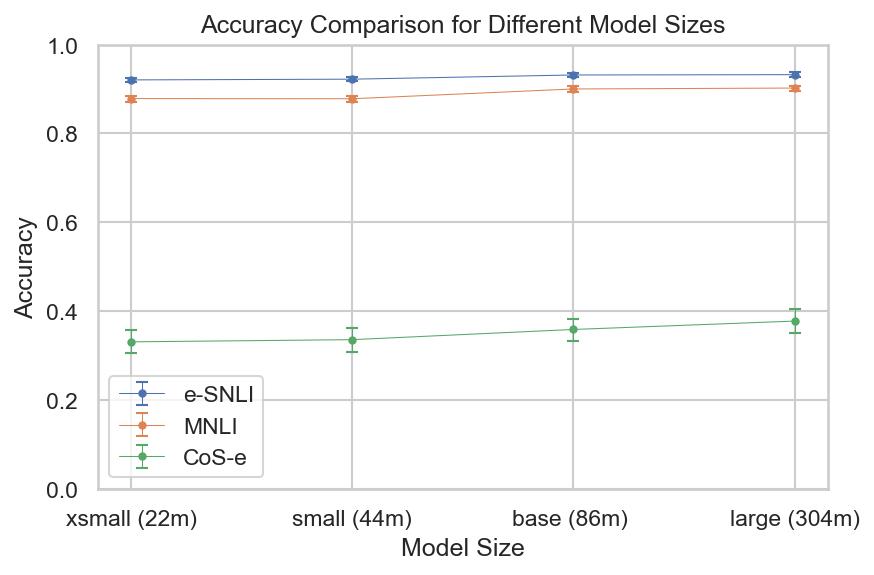

In [85]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

# Define your datasets and model_names if not already defined
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']
model_sizes = ['xsmall (22m)', 'small (44m)', 'base (86m) ', 'large (304m)']

# Iterate through each dataset
for i, dataset in enumerate(datasets):
    dataset_results = results[dataset]
    accuracies = [dataset_results[model]['accuracy'] for model in model_names]
    
    # Extract confidence intervals for the dataset and models
    conf_intervals = [confidence_intervals[dataset][model]['accuracy'] for model in model_names]
    
    # Separate the lower and upper bounds of the confidence intervals
    lower_bounds = [acc - lower for acc, (lower, upper) in zip(accuracies, conf_intervals)]
    upper_bounds = [upper - acc for acc, (lower, upper) in zip(accuracies, conf_intervals)]

    # Plot with error bars
    ax.errorbar(model_sizes, accuracies, yerr=[lower_bounds, upper_bounds], 
                marker='o',capsize=3 , markersize=3, label=dataset_labels[i], linewidth=0.5)

ax.set_title("Accuracy Comparison for Different Model Sizes")
ax.set_xlabel("Model Size")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)  # Set y-axis limits to 0 to 1
ax.legend()

plt.tight_layout()
plt.show()



# Tables

In [98]:
import pandas as pd

def create_table(metrics=['accuracy']):
    # Creating an empty list to store the rows
    rows = []

    # Iterate through the nested dictionary to populate the list
    for dataset in results:
        for size in results[dataset]:
            if size == 'true':
                continue
            for metric, value in results[dataset][size].items():
                if metric not in metrics or metric == 'pred':
                    continue
                conf_interval = confidence_intervals[dataset][size][metric]
                conf_interval_rounded = (round(conf_interval[0],5), round(conf_interval[1],5))
                value_rounded = round(value, 5)
                rows.append([dataset, size, metric, value_rounded, conf_interval_rounded])

    # Create a DataFrame
    df = pd.DataFrame(rows, columns=['Dataset', 'Model_Size', 'Metric', 'Value', '95% C.I.'])
    return df

# Display the DataFrame
df_accurary = create_table(metrics=['accuracy'])
df_all_metrics = create_table(metrics=['accuracy', 'percision', 'recall', 'f1'])

df_accurary.head(50)

,Dataset,Model_Size,Metric,Value,95% C.I.
0,esnli,xsmall,accuracy,0.92034,"(0.91485, 0.92562)"
1,esnli,small,accuracy,0.92197,"(0.91688, 0.92735)"
2,esnli,base,accuracy,0.93142,"(0.92654, 0.9366)"
3,esnli,large,accuracy,0.93213,"(0.92725, 0.93721)"
4,mnli,xsmall,accuracy,0.87835,"(0.87162, 0.88467)"
5,mnli,small,accuracy,0.87794,"(0.87121, 0.88406)"
6,mnli,base,accuracy,0.89995,"(0.89404, 0.90565)"
7,mnli,large,accuracy,0.90199,"(0.89628, 0.90769)"
8,cose,xsmall,accuracy,0.33088,"(0.30467, 0.3579)"
9,cose,small,accuracy,0.33579,"(0.30876, 0.362)"


In [97]:
# saving the dataframe
df_accurary.to_csv('results/df_accurary.csv', index=False)
df_all_metrics.to_csv('results/df_all_metrics.csv', index=False)

In [99]:
df_all_metrics.head(50)

,Dataset,Model_Size,Metric,Value,95% C.I.
0,esnli,xsmall,accuracy,0.92034,"(0.91485, 0.92562)"
1,esnli,xsmall,percision,0.92025,"(0.91455, 0.92543)"
2,esnli,xsmall,recall,0.92016,"(0.91495, 0.92509)"
3,esnli,xsmall,f1,0.92020,"(0.91478, 0.92533)"
4,esnli,small,accuracy,0.92197,"(0.91688, 0.92735)"
5,esnli,small,percision,0.92192,"(0.91664, 0.92708)"
6,esnli,small,recall,0.92178,"(0.91602, 0.92698)"
7,esnli,small,f1,0.92184,"(0.9162, 0.92732)"
8,esnli,base,accuracy,0.93142,"(0.92654, 0.9366)"
9,esnli,base,percision,0.93141,"(0.92635, 0.93628)"
